In [95]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn 
import torch.functional as F 
from torch.utils.data import Dataset, DataLoader

raw_data = loadarff('/home/sai-admin/ECG5000_TRAIN.arff')
train = pd.DataFrame(raw_data[0])

raw_data = loadarff('/home/sai-admin/ECG5000_TEST.arff')
test = pd.DataFrame(raw_data[0])

df = train._append(test, ignore_index=True)
df = df.sample(frac=1.0)
df.shape


(5000, 141)

[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

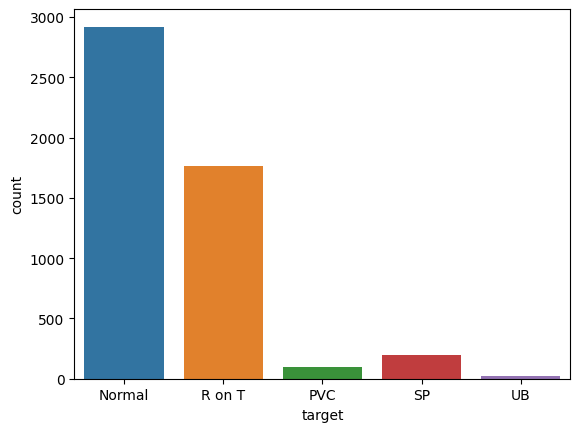

In [96]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

ax = sns.countplot(data=df, x="target")
ax.set_xticklabels(class_names)


In [97]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)

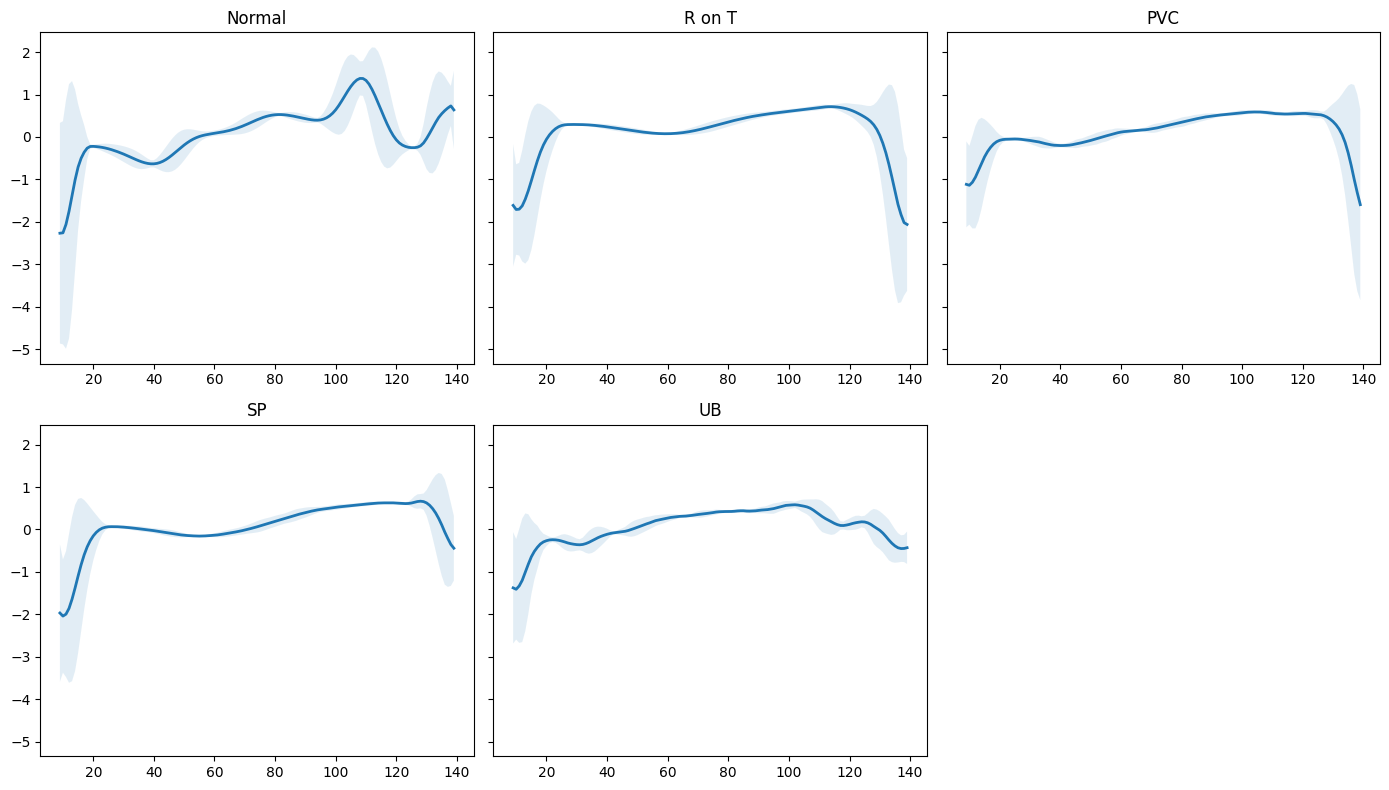

In [98]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

In [99]:
normal_df = df[df.target == b'1'].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [100]:
anomaly_df = df[df.target != b'1'].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [101]:
RANDOM_SEED = 42
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [102]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    dataset = torch.stack(dataset)
    n_seq, seq_len, n_features = dataset.shape
    return dataset, seq_len, n_features

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

class GetDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset 
    
    def __getitem__(self, org_index):
        return self.dataset[org_index]

    def __len__(self):
        return self.dataset.shape[0]
    
train_dataset = GetDataset(train_dataset)
val_dataset = GetDataset(val_dataset)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

In [103]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=16):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features, # 1
      hidden_size=self.hidden_dim, # 32
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim, 
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x, (_, _) = self.rnn1(x) # the shape of x is 1x140x32
    x, (hidden_n, _) = self.rnn2(x)
    flat_dim = self.rnn2.num_layers*2*self.embedding_dim if self.rnn2.bidirectional else self.rnn2.num_layers*self.embedding_dim
    return hidden_n.permute(1,0,2).view(-1,flat_dim).unsqueeze(1)
  
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(1, self.seq_len, 1)
    x, (_, _) = self.rnn1(x)
    x, (_, _) = self.rnn2(x)
    x = x.reshape((-1, self.hidden_dim))
    x = self.output_layer(x)
    return x.reshape(-1, self.seq_len, self.n_features)
  
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x
  
model = RecurrentAutoencoder(seq_len=140, n_features=1, embedding_dim=16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [104]:
def train_model(model, train_dataloader, val_dataloader, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataloader:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataloader:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [105]:
model, history = train_model(
  model, 
  train_dataloader, 
  val_dataloader, 
  n_epochs=4000
)

Epoch 1: train loss 5948.451985677083 val loss 5458.82744140625
Epoch 2: train loss 5945.539663461538 val loss 5455.77685546875
Epoch 3: train loss 5941.05719150641 val loss 5450.45947265625
Epoch 4: train loss 5932.1526442307695 val loss 5438.54853515625
Epoch 5: train loss 5906.897348257212 val loss 5394.240234375
Epoch 6: train loss 5657.195763221154 val loss 4517.083544921875
Epoch 7: train loss 4639.659204727564 val loss 4110.71162109375
Epoch 8: train loss 4499.184789413061 val loss 4113.09638671875
Epoch 9: train loss 4479.360601963141 val loss 4079.02041015625
Epoch 10: train loss 4469.48883213141 val loss 4076.7337890625
Epoch 11: train loss 4462.317958733975 val loss 4065.39990234375
Epoch 12: train loss 4463.4541015625 val loss 4063.50234375
Epoch 13: train loss 4464.434482672275 val loss 4060.1337890625
Epoch 14: train loss 4450.032602163462 val loss 4058.480224609375
Epoch 15: train loss 4447.655298477564 val loss 4058.8875
Epoch 16: train loss 4445.125250400641 val loss 4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


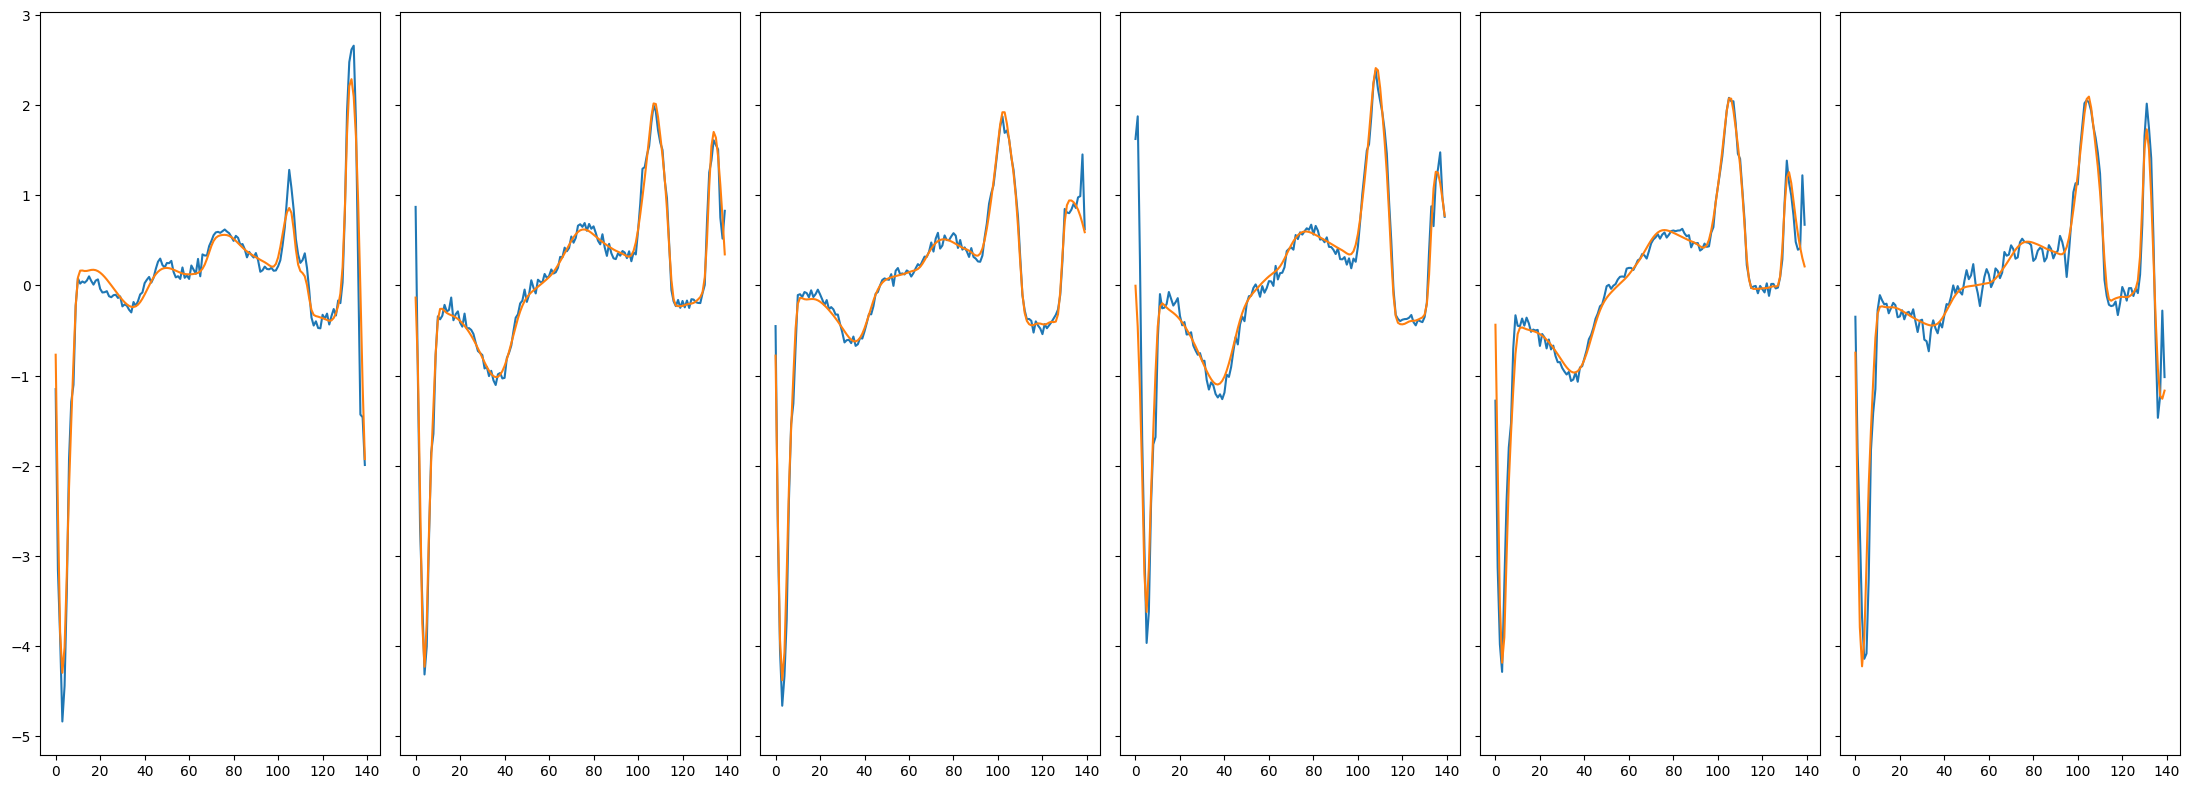

In [106]:
fig, axs = plt.subplots(
  nrows=1,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

model = model.eval()
for data in val_dataloader:
  data = data.to(device)
  predictions = model(data)
  for i in range(6):
    pred = predictions[i].squeeze(-1).cpu().detach().numpy()
    true = data[i].squeeze(-1).cpu().numpy()
    axs[i].plot(true, label='true')
    axs[i].plot(pred, label='reconstructed')
    ax.legend()
  break

fig.tight_layout()